# Data Parser

In [7]:
import os
import glob
from tqdm import tqdm

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' 
# Ignoring SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame

import numpy as np
import nibabel as nib
from sklearn.preprocessing import LabelEncoder
import torch
import torch.utils.data as data

In [8]:
def load_nii_to_array(nii_path):
    
    """ 
    Function returns np.array data from the *.nii file
    
    Arguments:
        * nii_path (str): path to *.nii file with data

    Output:
        * result (np.array): data obtained from nii_path
    """
    
    try:
        result = np.asanyarray(nib.load(nii_path).dataobj)
        return (result)
    
    except OSError:
        print(FileNotFoundError(f'No such file or no access: {nii_path}'))
        return('')

In [3]:
def crope_image(img, coord_min, img_shape):
    
    """
    Function cropes an image 
    
    Arguments:
        * img (np.array): MR image
        * coord_min (x_min, y_min, z_min):  the most bottom coordinate
        * img_shape (x_shape, y_shape, z_shape): desired image shape

    Output:
        * img (np.array): croped image with size (1, x_shape, y_shape, z_shape)
    """
    
    img = img[coord_min[0]:coord_min[0] + img_shape[0],
              coord_min[1]:coord_min[1] + img_shape[1],
              coord_min[2]:coord_min[2] + img_shape[2],]
    
    if img.shape[:3] != img_shape:
        print(f'Current image shape: {img.shape[:3]}')
        print(f'Desired image shape: {img_shape}')
        raise AssertionError
        
    return img.reshape((1,) + img_shape)

In [4]:
def get_targets_info(sample, 
                     targets_path = 'targets/targets_fcd_bank.csv',
                     image_path='../../datasets/fcd_classification_bank',
                     mask_path = False,
                     prefix = False,
                     data_type = False,
                     ignore_missing = True):
    
    '''
    Function to obtain DataFrame with all the information about
    needed MR images (including paths to MRI and to file with ground truth segmentation).
    Walks through directories and completes DataFrame, according to targets.
    
    Arguments:
        * targets_path (str): path to DataFrame with all the information about MR images.
        * sample (str): name of the medical center with images from which we want to work, 'all' for whole centers
        * prefix (str): patient name prefix (optional). In case we want to work e.g only with fcd or no_fcd patients.
        * mask_path (str or False): paths to mask folders 
        * image_path (str): path to nii.gz files with MR data
        * data_type (str or False): str - 'img' or'seg'. If e.g data_type = 'img' - only MR image is used for model.
        'img' or 'seg' are using in classification, in segmentation data_type = False, since we want to have both. 
        * ignore_missing (bool): whther we want to remove examples with missing data or not.
    
    Outputs:
        * files: DataFrame with all the information about targets, which are needed for our task
        (including paths to MRI and to file with ground truth segmentation)
    '''
    
    
    description_of_targets = pd.read_csv(targets_path, index_col = 0)
    '''
    DataFrame with infromation about each MRI
        * sample: 'pirogov', 'la5_study', 'soloviev', 'hcp', 'kulakov'. Names of medical centers from which MR images were obtained
        * patien: names of MR images 
        * fcd: 1 or 0. Responsible for the presence or absence of the FCD in MR images  
        * age: ages of patients, whose MR images we have
        * gender: gender of patients, whose MR images we have
        * scan: . To be honest don't know 
        * detection: ['mri_positive', 'mri_negative', nan, 'mri_positive/mri_negative']. To be honest don't know
        * comments: [nan,  0.,  3.,  2.,  1.]. To be honest don't know
    '''
    
    files = pd.DataFrame(columns = ['patient','scan','fcd','img_file','img_seg']) # output DataFrame
    condition_about_sample = (description_of_targets['sample'] == sample)
                         
    if prefix:
        condition_about_sample = (description_of_targets['sample'] == sample)&(description_of_targets['patient'].str.startswith(prefix))
        
    files['patient'] = description_of_targets['patient'][condition_about_sample].copy()
    files['fcd'] = description_of_targets['fcd'][condition_about_sample].copy()
    files['scan'] = description_of_targets['scan'][condition_about_sample].copy()
    files['detection'] = description_of_targets['detection'][condition_about_sample].copy()
    files['comments'] = description_of_targets['comments'][condition_about_sample].copy()
    
    if mask_path:
        files['img_mask'] = ''
    
    elif sample == 'all':
        files['patient'] = description_of_targets['patient'].copy()
        files['fcd'] = description_of_targets['fcd'].copy()
        files['scan'] = description_of_targets['scan'].copy()
        files['detection'] = description_of_targets['detection'].copy()
        files['comments'] = description_of_targets['comments'].copy()
        
    # paths to MRI and corresponding segmentation are adding
    for i in tqdm(range(len(files))):
        for file_in_folder in glob.glob(os.path.join(image_path,'*norm*')):
            if sample == 'pirogov':
                if (files['patient'].iloc[i] + '_norm.nii.gz') == file_in_folder.split('/')[-1]:
                    files['img_file'].iloc[i] = file_in_folder
            else:
                if files['patient'].iloc[i] in file_in_folder:
                    files['img_file'].iloc[i] = file_in_folder

        for file_in_folder in glob.glob(os.path.join(image_path,'*aseg*')):
            if sample == 'pirogov':
                if ((files['patient'].iloc[i] +'_aparc+aseg.nii.gz') == file_in_folder.split('/')[-1]) or\
                ((files['patient'].iloc[i] +'_aparc+aseg.nii') == file_in_folder.split('/')[-1]):
                    files['img_seg'].iloc[i] = file_in_folder 
            else:    
                if files['patient'].iloc[i] in file_in_folder:
                    files['img_seg'].iloc[i] = file_in_folder   

        if mask_path:
            for file_in_folder in glob.glob(os.path.join(mask_path,'*.nii*')):
                if (files['patient'].iloc[i] +'.nii.gz') == file_in_folder.split('/')[-1]:
                    files['img_mask'].iloc[i] = file_in_folder 
    
    # treating missing data
    if ignore_missing:
        # if only 'img' is needed for classification
        if data_type =='img':
            files.dropna(subset = ['img_file'], inplace= True)
        # if only 'seg' is needed for classification
        elif data_type =='seg':
            files.dropna(subset = ['img_seg'], inplace= True)
        # saving only full pairs of data. Mandatory for segmentation 
        else: 
            files.dropna(subset = ['img_seg','img_file'], inplace= True)

    # reindexing an array, since we droped NaNs.
    files = files.reset_index(drop=True)
    label_encoder = LabelEncoder() 
    files['scan'] = label_encoder.fit_transform(files['scan'])

    return files, label_encoder

In [37]:
"""
data.Dataset is an abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`.
"""

class DataMriSegmentation(data.Dataset):
    
    """
    Arguments:
        image_path (str): paths to data folders  
        mask_path (str): paths to mask folders  
        prefix (str): patient name prefix (optional)
        sample (str): subset of the data, 'all' for whole sample
        targets_path (str): targets file path
        if ignore_missing (bool): delete subject if the data partially missing
        mask (string): ['seg', 'bb', 'combined']    
    """
    
    def __init__(self, sample,
                 image_path = '../../datasets/fcd_classification_bank',
                 targets_path = 'targets/targets_fcd_bank.csv',
                 mask_path = False,
                 prefix = False,
                 ignore_missing = True,
                 coord_min = (30,30,30, ),
                 img_shape = (192, 192, 192, ),
                 mask = 'seg'):
        
        super(DataMriSegmentation, self).__init__()
        
        print(f'Assembling data for: {sample} sample.')
        files, label_encoder = get_targets_info(sample, targets_path, image_path,
                                 mask_path, prefix, ignore_missing)
        
        self.img_files = files['img_file']
        self.img_seg = files['img_seg']
        self.scan = files['scan']
        self.scan_keys = label_encoder.classes_
        self.target = files['fcd'] 
        self.detection = files['detection']
        self.misc = files['comments']
        
        if mask_path:
            self.img_mask = files['img_mask']
            
        self.coord_min = coord_min
        self.img_shape = img_shape
        self.mask_path = mask_path
        self.mask = mask
        
        assert mask in ['seg','bb','combined'], "Invalid mask name!"
            
    def __getitem__(self, index):
            img_path = self.img_files[index]
            seg_path = self.img_seg[index]
            
            img_array = load_nii_to_array(img_path)
            seg_array = load_nii_to_array(seg_path)
                                   
            img = crope_image(img_array, self.coord_min, self.img_shape)
            seg = crope_image(seg_array, self.coord_min, self.img_shape)
                                   
            if self.mask == 'seg':
                # binarising cortical structures
                seg[seg < 1000] = 0
                seg[seg > 1000] = 1
                return torch.from_numpy(img).float(), torch.from_numpy(seg).float()

            elif self.mask == 'bb':
                # preparing bounding box mask 
                bb_mask_path = self.img_mask[index]
                mask_array = load_nii_to_array(bb_mask_path)
                masked_img = crope_image(mask_array, self.coord_min, self.img_shape)
                return torch.from_numpy(img).float(), torch.from_numpy(masked_img).float()
            
            elif self.mask == 'combined':
                # binarising cortical structures
                seg[seg < 1000] = 0
                seg[seg > 1000] = 1
                
                # preparing bounding box mask 
                bb_mask_path = self.img_mask[index]
                mask_array = load_nii_to_array(bb_mask_path)
                masked_img = crope_image(mask_array, self.coord_min, self.img_shape)
                
                # calculating combined mask as intersection of both masks
                comb_mask = np.logical_and(masked_img, seg)
                return torch.from_numpy(img).float(), torch.from_numpy(comb_mask).float()

    def __len__(self):
        return len(self.img_files)

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

In [2]:
def plot_central_cuts(img):
    
    """
    Function plots central slices of MRI
    
    Arguments:
        * img (torch.Tensor): MR image (1xDxHxW)
    
    Output:
        * picture of central slices of MRI
    """
    
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    

In [23]:
from ipywidgets import IntSlider, interact

def plot_img(img, cmap = 'gray'):
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap=cmap)
    plt.show()

def create_slider(img):
    sld_sagital = IntSlider(min=0, max=img.shape[0]-1, step=1, continuous_update=True)
    sld_coronal = IntSlider(min=0, max=img.shape[1]-1, step=1, continuous_update=True)
    sld_axial   = IntSlider(min=0, max=img.shape[2]-1, step=1, continuous_update=True)
    return sld_sagital, sld_coronal, sld_axial


def vary_coordinate(coordinate_sagital, coordinate_coronal, coordinate_axial, axis = None):
    if axis == None:
        pass
    if axis == 'sagital':
        plot_img(img[coordinate_sagital,:,:])
    if axis == 'coronal':
        plot_img(img[:,coordinate_coronal ,:])
    if axis == 'axial':
        plot_img(img[:,:, coordinate_axial])
    

In [24]:
img = load_nii_to_array('../../datasets/fcd_classification_bank/fcd_0_1_norm.nii.gz')

In [36]:
#!jupyter nbextension enable --sys-prefix --py widgetsnbextension

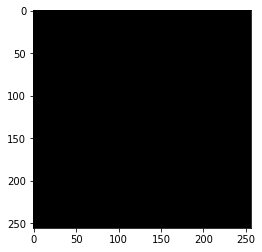

In [33]:
sld_sagital = IntSlider(min=0, max=img.shape[0]-1, step=1, continuous_update=True)
sld_coronal = IntSlider(min=0, max=img.shape[1]-1, step=1, continuous_update=True)
sld_axial   = IntSlider(min=0, max=img.shape[2]-1, step=1, continuous_update=True)

interact(vary_coordinate,
         coordinate_axial = sld_axial,
         coordinate_sagital = sld_sagital,
         coordinate_coronal = sld_coronal,
         axis = 'axial');

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()
    
def plot_difference(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = (img[ img.shape[0] // 2 + delta, :, :] - seg[ seg.shape[0] // 2 + delta, :, :])*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()